In [181]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [182]:
# อ่านไฟล์ CSV
file_path = 'motion-1_Walking-Man.csv'  # กำหนดไฟล์ CSV
df = pd.read_csv(file_path)  # อ่านข้อมูลจากไฟล์ CSV

# แสดง DataFrame ในรูปแบบตาราง
df

,frames,x0,y0,z0,x1,y1,z1,x2,y2,z2,...,z29,x30,y30,z30,x31,y31,z31,x32,y32,z32
0,0,893,172,-0.095574,884,157,-0.085922,882,156,-0.085941,...,0.296203,825,864,0.097397,832,817,0.263029,914,865,0.037191
1,1,893,162,-0.111072,883,147,-0.100866,882,147,-0.100871,...,0.281613,817,866,0.067486,835,819,0.245276,902,867,-0.007908
2,2,891,158,-0.090349,881,143,-0.079990,880,143,-0.080005,...,0.234854,802,863,0.040633,866,823,0.192049,886,864,-0.038452
3,3,891,157,-0.068701,881,142,-0.058335,879,142,-0.058358,...,0.163304,778,862,0.005889,916,829,0.110296,858,865,-0.080613
4,4,891,158,-0.061929,881,143,-0.051066,879,143,-0.051095,...,0.161706,746,863,-0.018249,957,828,0.111453,838,866,-0.100065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,351,943,219,-0.095938,935,205,-0.084875,934,205,-0.084902,...,0.193280,914,845,0.058978,748,815,0.163805,983,851,0.010655
352,352,943,216,-0.103900,935,202,-0.094158,934,202,-0.094163,...,0.195866,895,844,0.034069,810,817,0.168953,959,848,-0.019323
353,353,943,210,-0.110387,935,196,-0.100769,934,196,-0.100783,...,0.240501,821,812,0.069845,924,819,0.200803,883,843,0.000072
354,354,943,203,-0.107354,935,188,-0.097674,934,188,-0.097689,...,0.248344,846,829,0.068012,892,813,0.214634,922,843,0.000608


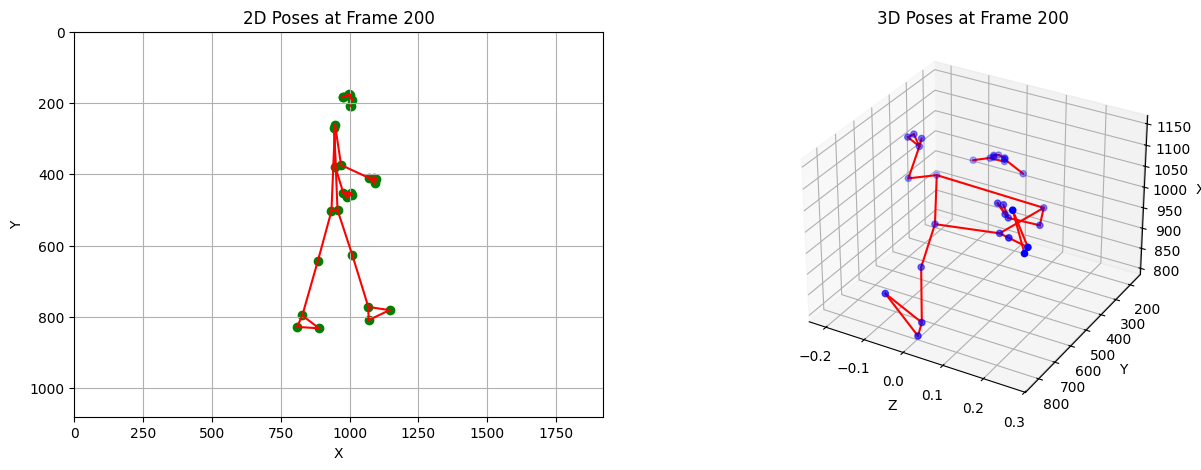

In [183]:
# ฟังก์ชันสำหรับการสร้าง skeleton พร้อม grid
def plot_skeleton(frame_data, frame_number):
    # กำหนดจุด landmark ที่จะเชื่อมต่อกัน
    connections = [
        (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8), (9, 10),  # หัว
        (11, 12), (12, 24), (24, 23), (23, 11),  # ลำตัว
        (11, 13), (13, 15), (12, 14), (14, 16), # แขน
        (15, 17), (15, 21), (15, 19), (19, 17), # มือซ้าย
        (16, 18), (16, 22), (16, 20), (20, 18), # มือขวา
        (23, 25), (25, 27), (27, 29), (29, 31), (31, 27),  # ขาขวา
        (24, 26), (26, 28), (28, 30), (30, 32), (28, 32)  # ขาซ้าย
    ]
    
    # ดึงค่าข้อมูล x และ y สำหรับแต่ละ landmark
    x_vals = [frame_data[f'x{i}'] for i in range(33)]
    y_vals = [frame_data[f'y{i}'] for i in range(33)]
    z_vals = [frame_data[f'z{i}'] for i in range(33)]
    
    # สร้างภาพแบบ subplot ที่มี 2D และ 3D
    fig = plt.figure(figsize=(15, 5))
    
    # วาด 2D skeleton ใน subplot แรก
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title(f'2D Poses at Frame {frame_number}')
    ax1.scatter(x_vals, y_vals, c='green')  # วาดจุด
    for conn in connections:
        ax1.plot([x_vals[conn[0]], x_vals[conn[1]]], [y_vals[conn[0]], y_vals[conn[1]]], 'r-')  # วาดเส้นเชื่อมต่อ
    ax1.grid(True)  # เปิดกริด
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    
    # กำหนดขนาดสูงสุดของแกน
    ax1.set_xlim(0, 1920)  # ตั้งค่าขนาดแกน x
    ax1.set_ylim(1080, 0)  # ตั้งค่าขนาดแกน y

    # ************************************** กำลังแก้
    # วาด 3D skeleton ใน subplot ที่สอง
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_title(f'3D Poses at Frame {frame_number}')
    
    # ******* ตรงนี้ต้องกลับมาดูใหม่
    # ลำดับค่าพิกัด: 1 เป็นความลึก, 2 เป็นความสูง (invert), 3 เป็นแนวกว้าง
    ax2.scatter(z_vals, y_vals, x_vals, c='blue')  # วาดจุด

    for conn in connections:
        ax2.plot([z_vals[conn[0]], z_vals[conn[1]]],  
                 [y_vals[conn[0]], y_vals[conn[1]]],  
                 [x_vals[conn[0]], x_vals[conn[1]]], 'r-') 
    
    ax2.set_xlabel('Z')  
    ax2.set_ylabel('Y')  
    ax2.set_zlabel('X') 
    ax2.invert_yaxis()  # ให้แกน Y invert
    ax2.grid(True)  # เปิดกริด

    plt.show()

# แสดง skeleton สำหรับเฟรมที่เลือก
selected_frames = [200]

# แสดง skeleton
for frame in selected_frames:
    frame_data = df[df['frames'] == frame].iloc[0]
    plot_skeleton(frame_data, frame)